In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
import networkx.algorithms.community.quality as nxq
import community as community_louvain
import unittest
import math
from time import time

# Louvain Community Detection Algorithm

## Utils

In [2]:
def load_graph(file_path):
    """Loads graph from file txt"""
    
    assert ('txt' in file_path), 'Please choose a graph file of type txt'

    G = nx.read_edgelist(file_path,create_using=nx.Graph(), nodetype = int)
    return G

In [3]:
def community_to_dict(partition):
    """Converts a partition of the following form:
    partition = [{nodes of com 1}, {nodes of com 2}, ..., ] into a dict with the nodes as keys and the community as value"""
    part = {}
    for i, com in enumerate(partition):
        for node in com:
            part[node] = i
    return part

In [4]:
def from_dict_to_list(partition):
    """Perfomrs the inverse operation of the community_to_dict function"""
    num_part = max(partition.values())
    part = [[] for i in range(num_part+1)]
    for node in partition:
        part[partition[node]].append(node)
    return part

In [5]:
def find_community_i(partition, node):
    """Finds the index of the community of node"""
    for ind, com in enumerate(partition):
        if node in com:
            return ind

In [6]:
def delete_from_com(partition, ind, node):
    """Deletes node from community with index ind"""
    part = deepcopy(partition)
    part[ind].remove(node)
    return part

In [7]:
def add_to_community(partition, ind, node):
    """Adds node to the community of index ind"""
    partition = deepcopy(partition)
    partition[ind].add(node)
    return partition

In [8]:
def singleton_partition(graph):
    """Initializes the partition to all nodes form a community"""
    partition = []
    for node in graph.nodes():
        partition.append({node})
    return partition

In [9]:
def get_best_partition(graph, best_partition, best_mod, node, part):
    """Gets best partition by removing node to its neighbors' communities"""

    ind_node = find_community_i(part, node)
    neigh_node = graph.neighbors(node)

    # visit all nieghbors of the node
    for neigh in neigh_node:

        # make copy of part to not change the initial part
        part_bis = deepcopy(part)
        ind_neigh = find_community_i(part_bis, neigh)
        part_bis = delete_from_com(part_bis, ind_node, node)
        part_bis = add_to_community(part_bis, ind_neigh, node)
        part_bis = [s for s in part_bis if s != set()]

        # compute modularity of new partition
        mod = nxq.modularity(graph, part_bis, weight='weight') 

        # update modularity
        if mod > best_mod:
            best_mod = mod
            best_partition = part_bis

    return best_mod, best_partition 

In [10]:
def size_link_between_com(com1, com2, graph):
    """Gets the weight of the edge between two communities"""

    link = 0
    for node1 in com1:
        for node2 in com2:
            data = graph.get_edge_data(node1, node2)
            if data != None:
                if data != {}:
                    link += data['weight']
                else:
                    link += 1
    return link

In [11]:
def merge_communities(communities, best_communities):
    """Merges communities during the iterations of the Louvain algorithm (it > 1)"""

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            uni = uni.union(communities[element])
        new_communities.append(uni)
    return new_communities 

## Phase 1

In [12]:
def phase1(graph):
    """Gets the best partition by maximizing greedily the modularity function"""

    # initialize the communities: each node in a different community
    partition = singleton_partition(graph)

    # initialize the best modularity to spot convergence
    best_mod = nxq.modularity(graph, partition, weight='weight')
    best_partition = partition

    nodes = list(graph.nodes())
    random.shuffle(nodes)

    while 1:
        for node in nodes:
            part = deepcopy(best_partition)
            best_mod, best_partition = get_best_partition(graph, best_partition, best_mod, node, part)

        if part == best_partition:
            break

    return best_partition, best_mod

## Phase 2

In [13]:
def phase2(partition, graph):
    """Given a partition, computes the new graph with each community being a node"""

    # Get information from current graph
    nodes = graph.nodes()
    edges = graph.edges()

    # Initialize new graph
    new_nodes = [i for i in range(len(partition))]
    new_edges = []

    new_graph = nx.Graph()
    new_graph.add_nodes_from([i for i in range(len(partition))])


    for i, com1 in enumerate(partition):
        for j, com2 in enumerate(partition):
            if i >= j:
                if i == j:
                    # self_loops
                    nodes_in_com = [node for node in com1]
                    subGraph = graph.subgraph(nodes_in_com)
                    new_edges.append((i,i, {'weight':subGraph.size(weight='weight')}))
                else:
                    # weights between communities
                    link = size_link_between_com(com1, com2, graph)
                    if link > 0:
                        new_edges.append((i,j, {'weight':link}))

    new_graph.add_edges_from(new_edges)

    return new_graph

## Louvain

In [14]:
def louvain_algorithm(G):
    """Computes the best partition using the Louvain algorithm"""

    prev_best_partition, prev_best_mod = None, None

    partition = singleton_partition(G)

    First = True

    while 1:

        best_partition, best_mod = phase1(G)

        G = phase2(best_partition, G)

        if best_mod == prev_best_mod:
            break
        else:
            prev_best_partition, prev_best_mod = best_partition, best_mod

        if First:
            First = False
            partition = best_partition
        else:
            partition = merge_communities(partition, best_partition)

    return partition, best_mod

# Examples

In [17]:
def deg_best_result_of_N(graph_file, N):
    """Applies Louvain N times to increase the chances of getting the maximum modularity"""
    best_mod = -math.inf
    best_partition = None
    G = load_graph(graph_file)
    for i in range(N):
        partition, q = louvain_algorithm(G)
        if q > best_mod:
            best_mod = q
            best_partition = partition
    return best_partition, best_mod

## Karate club graph

### Our implementation

In [18]:
class PylouvainTest(unittest.TestCase):

    def test_karate_club(self):
        graph_file = 'karate.txt'
        partition, q = deg_best_result_of_N(graph_file, N=5)
        print(f'Best modularity found: {q}')
        print(f'Partition {partition}')
        q_ = q * 10000
        self.assertEqual(4, len(partition))
        self.assertEqual(4298, math.floor(q_))
        self.assertEqual(4299, math.ceil(q_))

In [19]:
PylouvainTest().test_karate_club()

Best modularity found: 0.42983639736886486
Partition [{0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22}, {17, 5, 6, 7, 11}, {32, 24, 25, 26, 28, 29}]


Time: 0.09477043151855469s
[{0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22, 29}, {17, 5, 6, 7, 11}, {32, 24, 25, 26, 28}]
Best modularity found: 0.4197166469893742


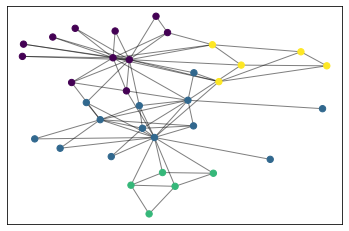

In [20]:
import matplotlib.cm as cm

t0 = time()

G = load_graph('karate.txt')
partition, q = louvain_algorithm(G)

print(f'Time: {time() - t0}s')
print(partition)

partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Open source implementation

0.4269691347613426
Best modularity found: 0.4269691347613426
Best partition found: {0: 0, 9: 0, 14: 1, 15: 0, 16: 0, 19: 0, 20: 1, 21: 0, 23: 0, 24: 0, 27: 0, 28: 0, 29: 2, 30: 0, 31: 0, 32: 2, 33: 0, 2: 1, 1: 1, 3: 1, 4: 1, 5: 3, 6: 3, 7: 3, 8: 1, 10: 1, 11: 3, 12: 1, 13: 1, 17: 3, 18: 1, 22: 1, 26: 2, 25: 2}


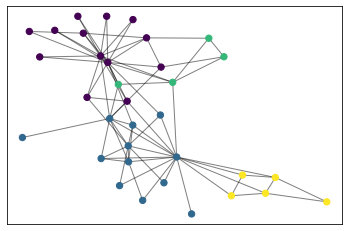

In [21]:
# Comparing with the open source implementation
import community as community_louvain
import matplotlib.cm as cm

# load the karate club graph
G = nx.read_edgelist('karate.txt',create_using=nx.Graph(), nodetype = int)

# compute the best partition
partition = community_louvain.best_partition(G)
print(community_louvain.modularity(partition, G))
print(f'Best modularity found: {community_louvain.modularity(partition, G)}')
print(f'Best partition found: {partition}')

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## DBLP Graph

### Our implementation

In [22]:
G = load_graph('com-dblp.ungraph.txt')
nodes = list(G.nodes())

In [23]:
G_sub = G.subgraph(nodes[0:100])

Time: 4.129533767700195s
Best modularity found: 0.51189168811159


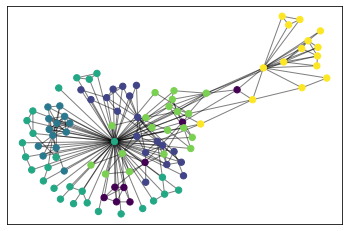

In [24]:
t0 = time()

partition, q = louvain_algorithm(G_sub)
partition = community_to_dict(partition)

print(f'Time: {time() - t0}s')

print(f'Best modularity found: {q}')


# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()

### Open Source implementation

Best modularity found: 0.5118916881115901


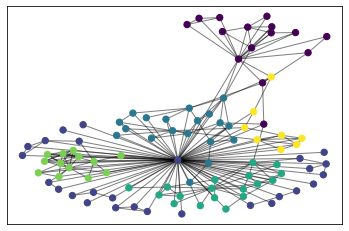

In [25]:
# compute the best partition
partition = community_louvain.best_partition(G_sub)
print(f'Best modularity found: {community_louvain.modularity(partition, G_sub)}')

# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()